# Qredo tokenomics simulation - single run example

#### Maria Silva, June 2023

## 1. Imports

In [1]:
import os
import timeit
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

from mechaqredo.params import default_params_dict
from mechaqredo.sim import run_single_sim

## 2. Set parameters

In [3]:
forecast_length = 365*3
file = os.path.realpath("../data/balances.csv")
wallet_df = pd.read_csv(file)
params_dict = default_params_dict(forecast_length)
params_dict["wallet_balances_vec"] = wallet_df["balance"].values

## 3. Run simulation

In [4]:
start = timeit.default_timer()
df = run_single_sim(forecast_length, params_dict)
stop = timeit.default_timer()
print("Run time for single sim: ", stop - start)
print("")
df["date"] = df["iteration"].apply(lambda x: params_dict["sim_start_datetime"]+dt.timedelta(days=x)).values
df.head()

Run time for single sim:  0.006880292000000399



,iteration,circ_supply,day_burned,day_vested,day_locked,day_released,staking_rewards_vested,staking_rewards_ecosystem,total_staking_rewards,validators_rewards,...,day_service_fee_locked,ecosystem_fund,staking_tvl,n_txs,token_price,service_fees,n_validators,day_inflation,year_inflation,date
0,0,5.122564e+08,350000004.0,5.050000e+08,1.777436e+08,1.750000e+08,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,11193.75,1.100000e+08,6.773243e+07,8000.0,0.08,3000.0,6.0,NaN,NaN,2023-07-15
1,1,5.523286e+08,4.0,2.551592e+05,1.219375e+04,3.982927e+07,94929.132588,3.982927e+07,3.992420e+07,1.996210e+07,...,11193.75,7.018192e+07,6.773343e+07,8000.0,0.08,3000.0,6.0,0.078227,NaN,2023-07-16
2,2,5.689038e+08,4.0,9.488407e+04,9.993244e+06,2.647359e+07,94884.074887,2.647359e+07,2.656848e+07,1.328424e+07,...,11193.75,4.371952e+07,7.771548e+07,8000.0,0.08,3000.0,6.0,0.030010,NaN,2023-07-17
3,3,5.792438e+08,4.0,9.483904e+04,6.654313e+06,1.689945e+07,94839.038572,1.689945e+07,1.699429e+07,8.497144e+06,...,11193.75,2.683127e+07,8.435860e+07,8000.0,0.08,3000.0,6.0,0.018175,NaN,2023-07-18
4,4,5.907586e+08,4.0,5.251131e+06,4.260766e+06,1.052438e+07,94794.023634,1.052438e+07,1.061917e+07,5.309585e+06,...,11193.75,1.631808e+07,8.860817e+07,8000.0,0.08,3000.0,6.0,0.019879,NaN,2023-07-19


## 4. Visualize results

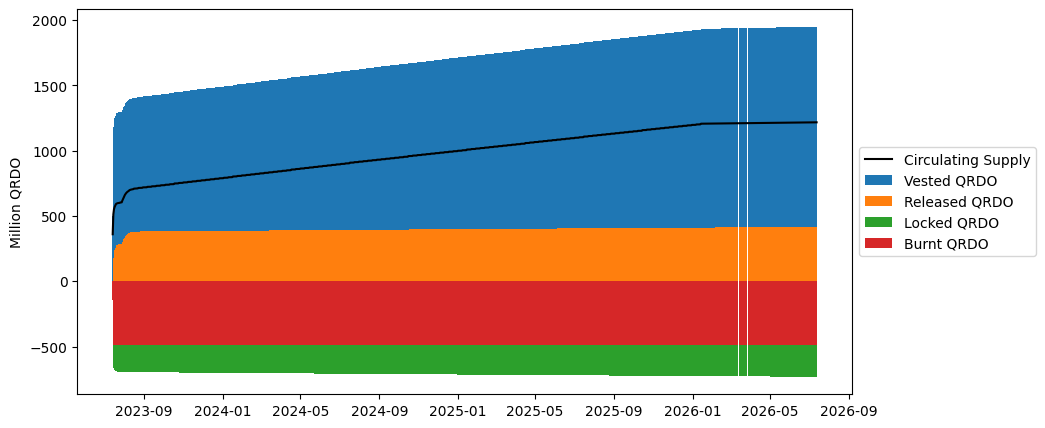

In [6]:
# Get values before sim
circ_supply_0 = np.array([params_dict["circ_supply_zero"]])
cum_burn_0 = np.array([140_000_000.0])
cum_vest_0 = np.array([params_dict["circ_supply_zero"]+140_000_000])
cum_lock_0 = np.array([0.0])
cum_release_0 = np.array([0.0])
date_0 = np.array([params_dict["sim_start_datetime"]-dt.timedelta(days=1)], dtype='datetime64[ns]')

# Build data vectors
circ_supply_vec = np.concatenate([circ_supply_0, df["circ_supply"].values])/ 10 ** 6
cum_burn_vec = np.concatenate([cum_burn_0, df["day_burned"].values]).cumsum()/ 10 ** 6
cum_vest_vec = np.concatenate([cum_vest_0, df["day_vested"].values]).cumsum()/ 10 ** 6
cum_lock_vec = np.concatenate([cum_lock_0, df["day_locked"].values]).cumsum()/ 10 ** 6
cum_release_vec = np.concatenate([cum_release_0, df["day_released"].values]).cumsum()/ 10 ** 6
date_vec = np.concatenate([date_0, df["date"].values])

# Plot supply
plt.figure(figsize=(10,5))
bar_width = 0.999
plt.bar(date_vec, cum_vest_vec+cum_release_vec, label="Vested QRDO",width=bar_width)
plt.bar(date_vec, cum_release_vec, label='Released QRDO',width=bar_width)
plt.bar(date_vec, -cum_lock_vec-cum_burn_vec, label="Locked QRDO",width=bar_width)
plt.bar(date_vec, -cum_burn_vec, label="Burnt QRDO",width=bar_width)
plt.plot(date_vec, circ_supply_vec, label="Circulating Supply", c="black")
plt.ylabel("Million QRDO")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

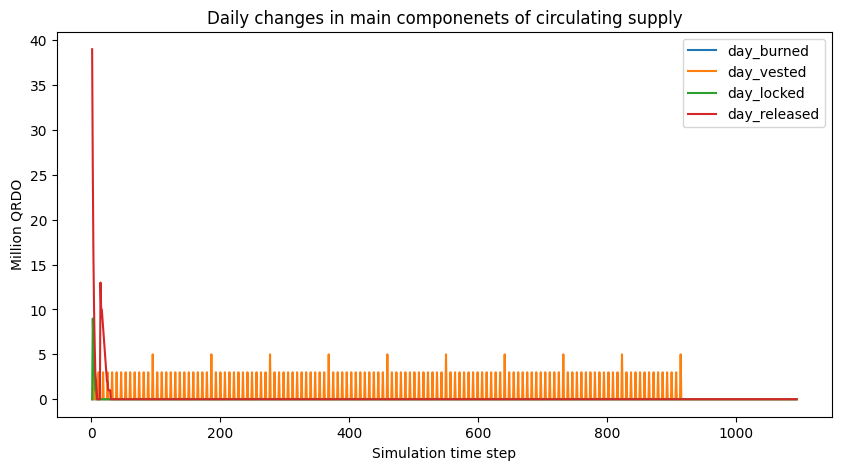

In [8]:
day_var_df = df[['day_burned', 'day_vested','day_locked', 'day_released']]// 10 ** 6
day_var_df.iloc[1:].plot(figsize=(10,5))
plt.title("Daily changes in main componenets of circulating supply")
plt.xlabel("Simulation time step")
plt.ylabel("Million QRDO")
plt.show()

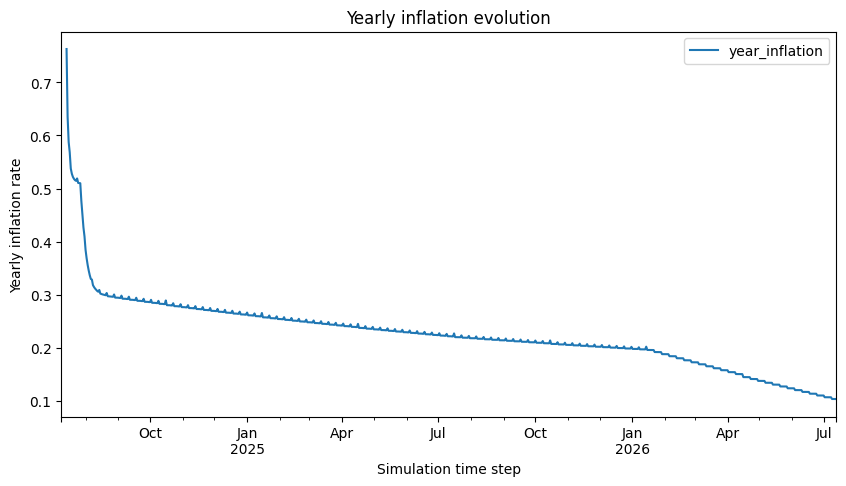

In [9]:
df.iloc[360:].plot(x="date", y="year_inflation", figsize=(10,5))
plt.title("Yearly inflation evolution")
plt.xlabel("Simulation time step")
plt.ylabel("Yearly inflation rate")
plt.show()